# Assignment 1 - Scott Wilkinson (V00887986) 

## Question 1: KNN Regression

A notebook which uses a KNN regression model to predict the time of merger of simulated galaxies from IllustrisTNG based on their non-parametric morphology data.

First, we must import the necessary Python packages.

In [1]:
# importing packages used in notebook
import numpy as np
import matplotlib.pyplot as plt
import pymysql, os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# BTW if you need a package installed, you can use the following

#import os
#os.system('pip install pymysql')

## Importing Morphology Data

See Data Assignment for more details.

In [3]:
#Query SQL for morphology data
# connects to database
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
# select morphology params that have unflagged morphology fits
#x = 'SELECT  dbID, asymmetry, shape_asymmetry, gini_m20_merger, concentration, outer_asymmetry, deviation, multimode, intensity \
    #FROM simCFIS_morph\
    #WHERE flag_morph = 0\
    #AND asymmetry > -1'
x = 'SELECT  dbID, asymmetry, shape_asymmetry, gini, m20, concentration\
    FROM simCFIS_morph\
    WHERE flag_morph = 0\
    AND asymmetry > -1'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

# save names as a string
names_morph = np.array(db_data, dtype = str).T[0]

# save rest of data as floats
morph = np.array(db_data, dtype = float).T[1:]

print(morph.shape)

(5, 219933)


# Merger Sample Selection

## Selecting a Sample of Pre-Merger Galaxies

Here is the reasoning behind my selection cuts:

1.  snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. rsep > 0 requires there to be two merging galaxies that are not on top of each other yet
3. mass ratio > 0.1, the merger will be significant when it occurs
4. Flaguntilmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code (see Hani et al. 2020, Rodriguez-Gomez et al. 2015)
5. Tuntilmerger < 0.5 ensures the merger will happen soon (< 500 Myr) and the galaxies have begun to gravitationally interact
6. Tpostmerger > 0.5 ensures no recent has occurred that would cause the disturbed morphology

In [4]:
#Query MySQL with reasoning described above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tuntilmerger, e.MassRatiountilmerger, s.SubhaloSFRinHalfRad\
    FROM Environment e, SFR s \
    WHERE e.DB_ID=s.DB_ID\
    AND e.snapNum>=50\
    AND rsep>0 \
    AND MassRatiountilmerger>=0.1\
    AND Flaguntilmerger = 1\
    AND Tuntilmerger < 0.5\
    AND Tpostmerger > 0.5\
    AND s.SubhaloSFRinHalfRad > -1'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_pre = np.array(db_data, dtype = str).T[0]
Mstar_pre = np.array(db_data, dtype = float).T[1]
Tum_pre = np.array(db_data, dtype = float).T[2]
mu_pre = np.array(db_data, dtype = float).T[3]
SFR_pre = np.array(db_data, dtype = float).T[4]

# give time before merger a negative value
Tum_pre *= -1

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tum_pre[Tum_pre == 0] = -0.05

# add 0 to match formatting with morphology catalogue
names_db_pre = np.array(['0'+n for n in names_db_pre])

print('There are {} pre-merger galaxies.'.format(len(names_db_pre)))

# match the two catalogues
match, idx_morph_pre, idx_pre = np.intersect1d(names_morph, names_db_pre, return_indices = True)

print('There are {} pre-merger galaxies with flag-free morphology data.'.format(len(names_db_pre[idx_pre])))

names_db_pre = names_db_pre[idx_pre]
Mstar_pre = Mstar_pre[idx_pre]
Tum_pre = Tum_pre[idx_pre]
mu_pre = mu_pre[idx_pre]
SFR_pre = SFR_pre[idx_pre]

There are 4917 pre-merger galaxies.
There are 1963 pre-merger galaxies with flag-free morphology data.


## Selecting a Sample of Post-Merger Galaxies

Here is the reasoning behind my selection cuts:

1. snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. mass ratio > 0.1, the merger that occurred was significant
3. Flagpostmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code
4. Tpostmerger < 0.5 requires a merger to have occurred in the last 500 Myr
5. rsep > 25 and Tuntilmerger < 0.5 requires there to be no nearby galaxies about to cause another merger in the next 500 Myr

In [5]:
#Query MySQL with the reasoning listed above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tpostmerger, e.MassRatio, s.SubhaloSFRinHalfRad\
    FROM Environment e, SFR s \
    WHERE e.DB_ID=s.DB_ID\
    AND e.snapNum>=50\
    AND MassRatio>=0.1\
    AND Flagpostmerger = 1\
    AND Tpostmerger < 0.5\
    AND rsep>25\
    AND Tuntilmerger > 0.5\
    AND s.SubhaloSFRinHalfRad > -1'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_post = np.array(db_data, dtype = str).T[0]
Mstar_post = np.array(db_data, dtype = float).T[1]
Tpm_post = np.array(db_data, dtype = float).T[2]
mu_post = np.array(db_data, dtype = float).T[3]
SFR_post = np.array(db_data, dtype = float).T[4]

# add 0 to match formatting with morphology catalogue
names_db_post = np.array(['0'+n for n in names_db_post])

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tpm_post[Tpm_post == 0] = 0.05

print('There are {} post-merger galaxies.'.format(len(names_db_post)))

# match with morphology catalogue
match, idx_morph_post, idx_post = np.intersect1d(names_morph, names_db_post, return_indices = True)

print('There are {} post-merger galaxies with flag-free morphology data.'.format(len(names_db_post[idx_post])))

names_db_post = names_db_post[idx_post]
Mstar_post = Mstar_post[idx_post]
Tpm_post = Tpm_post[idx_post]
mu_post = mu_post[idx_post]
SFR_post = SFR_post[idx_post]

There are 2951 post-merger galaxies.
There are 2059 post-merger galaxies with flag-free morphology data.


# Preparing Data for Model

In [6]:
# list of all merging galaxies, combines pre-mergers and post-mergers
names_mergers = np.array(list(names_db_pre) + list(names_db_post))
T_merger = np.array(list(Tum_pre) + list(Tpm_post))
mu = np.array(list(mu_pre) + list(mu_post))
mass = np.array(list(Mstar_pre) + list(Mstar_post))
sfr = np.array(list(SFR_pre) + list(SFR_post))

# match catalogues
match, idx_morph, idx_merge = np.intersect1d(names_morph, names_mergers, return_indices = True)

T_merger = T_merger[idx_merge]
mu = mu[idx_merge]
mass = mass[idx_merge]
sfr = sfr[idx_merge]
morph = morph[:,idx_morph]

In [7]:
# shape of input
print(morph.shape)

(5, 4022)


In [8]:
# shape of target
print(T_merger.shape)

(4022,)


In [9]:
# create training and validation sets (75/25 split)

input_tr,input_va,target_tr, target_va = train_test_split(morph.T, T_merger,test_size=0.25, shuffle = True)
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, mu, test_size=0.25, shuffle = True)
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, mass,test_size=0.25, shuffle = True)
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, sfr,test_size=0.25, shuffle = True)


### normalizing inputs

# fit on training set
scaler = StandardScaler().fit(input_tr)  

# normalize training
input_tr_norm= scaler.transform(input_tr) 

# normalize validation with same scaler & fit
input_va_norm= scaler.transform(input_va)

The commented-out lines in the above cell are relics of three additional attempts to fit different target parameters from IllustrisTNG: mass ratio, mass, and star formation rate. They performed slightly better than T_merger but still were poorly constrained by the model, as you will see for the case of T_merger. 

# K-Nearest Neighbours Regression

What follows is an attempt to predict the time of merger of simulated TNG galaxies using their non-parametric morphologies (like asymmetry, concentration, etc.). 

As per the assignment, I attempt a KNN regression on normalized input data and then on un-normalized input data to explore the importance of normalizing your data.

## Normalized Input Data

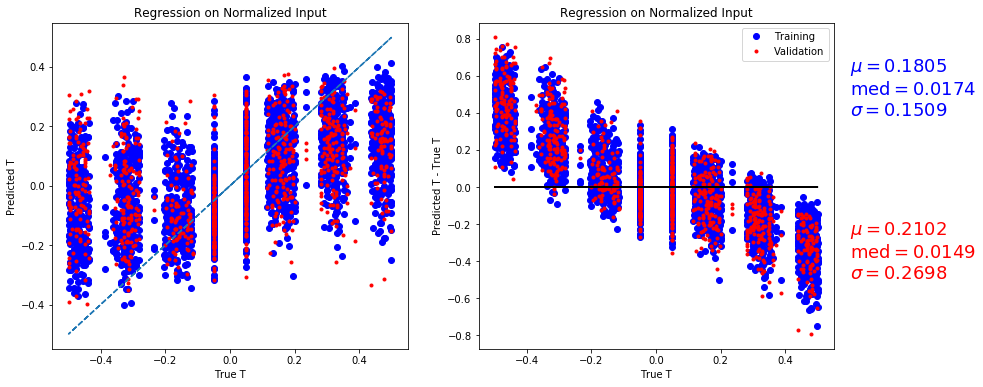

In [10]:
# define hyper parameters
KNN = KNeighborsRegressor(n_neighbors=10, p=2)

# fit the model with training set
KNN.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr_norm)  
target_va_pred= KNN.predict(input_va_norm)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True T')
ax1.set_ylabel('Predicted T')
ax1.set_title('Regression on Normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True T')
ax2.set_ylabel('Predicted T - True T')
ax2.set_title('Regression on Normalized Input')
ax2.legend(['Training', 'Validation'])

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(np.abs(target_tr-target_tr_pred))

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

On the left, I plot the predicted time of merger against the true time of merger from the simulation. I find that there is some trend, ie pre-mergers (to the left of 0) tend to have lower time predictions than post-mergers (those to the right of 0). However, very few galaxies lie along the one-to-one line indicating that almost no galaxies are being predicted accurately.

The same is true for the plot on the right. Very few galaxies lie along the horizonatal line of equality.

I report 3 metrics of performance on the right of the plots. The similar performance on the training and validation sets indicate there is not extreme overfitting or underfitting.

Please note that the mu that I report is different from most others. The fit is very poor but the average of the difference was almost perfectly 0. This is because (since my data is trending towards the average of my target distribution, more on that later) half of my predictions are underestimates and the other half are overestimates; averaging these across all predictions gives an average difference of 0 (see median which is approx. 0). 

Instead, I report here the average of the absolute difference between the true and predicted values; from this, we can see that on average, the predictions on the validation set are off by about 0.2 Gyr (very bad!).

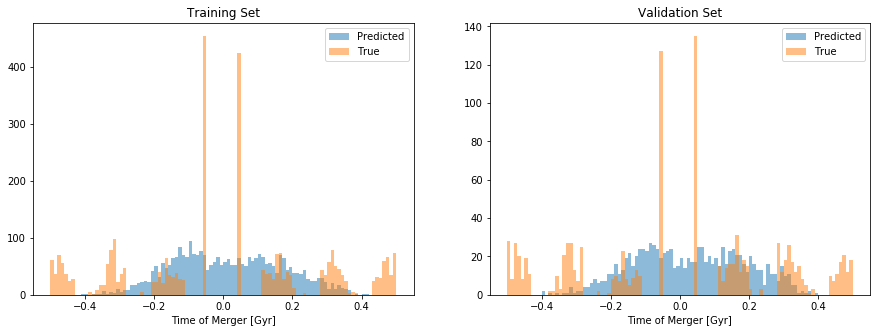

In [11]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Time of Merger [Gyr]')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Time of Merger [Gyr]')
ax2.legend(fancybox = True)

plt.show()

Here I plot the distributions of the true values of the target (orange) and the predicted values (blue) for the training set (left) and the validation set (right). By this method of visualizing the results, it can be seen that the KNN regression model NEVER predicts a galaxy to be on the edges of the target distribution. This is caused by the nature of the data itself and by the method of regression: galaxies on either end of the target distribution share similar characteristics (early on in the merger process, the galaxy looks fairly normal, calm, symmetric -- this is true 100's of Myr after the merger too!) and thus, appear in similar regions of parameter space. Averaging the targets of the nearest neighbours (the nearest neighbours in parameter space, span the target distribution) concludes that the galaxies predicted target must be near the average of the parameter space. This is exactly what we observe in both the training and validation set predictions.

## UN-Normalized Input Data

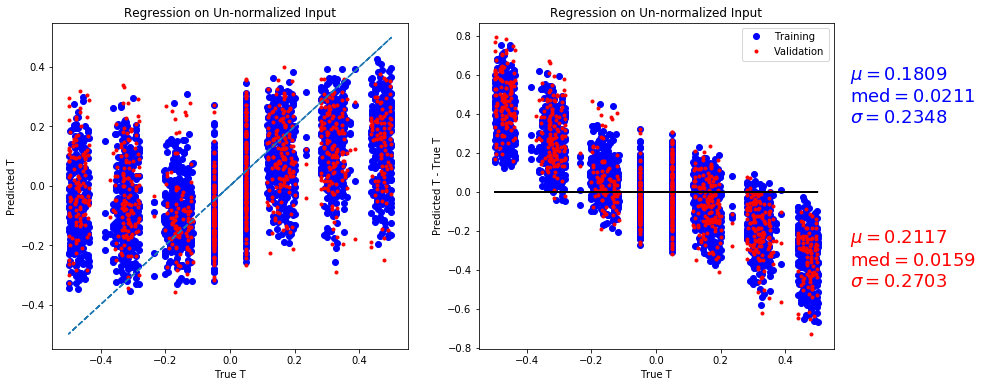

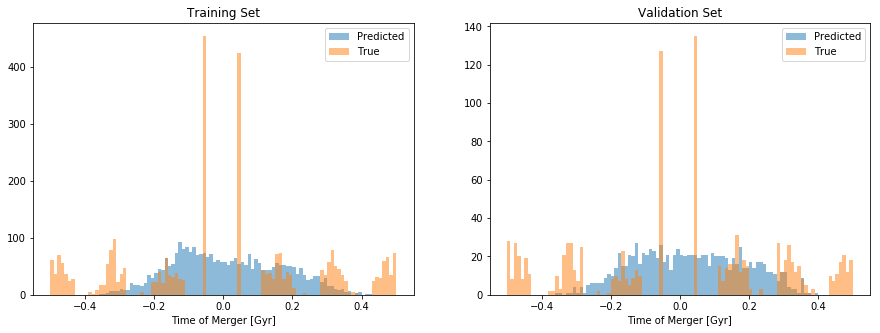

In [12]:
# define hyper parameters
KNN = KNeighborsRegressor(n_neighbors=10, p=2)

# fit the model with training set
KNN.fit(input_tr,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr)  
target_va_pred= KNN.predict(input_va)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True T')
ax1.set_ylabel('Predicted T')
ax1.set_title('Regression on Un-normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True T')
ax2.set_ylabel('Predicted T - True T')
ax2.set_title('Regression on Un-normalized Input')
ax2.legend(['Training', 'Validation'])

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(target_tr-target_tr_pred)

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Time of Merger [Gyr]')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Time of Merger [Gyr]')
ax2.legend(fancybox = True)

plt.show()

The unnormalized data performs approximately the same. This is not what I would have expected, as in class we discuss the importance of normalizing our data. I admit I don't fully understand why this might be! Let's try another data set and see if something changes.

In review, I have tried different k and p values, different targets, different inputs (via feature selection), different input normalization methods, changing my sample selection (reducing the time before and after the merger over which to consider) and nothing has been able to improve the performance of this model on this data/target. 

Next, I will try a similar but different data set to show that, at the very least, I can get my model to predict something, and maybe learn about normalization too.

# CHANGING DATA SET

The new data set is the same morphology parameters but for real galaxies, imaged using deep and high resolution CFIS imaging. 

I tried predicting global properties (like star formation rate) from the morphology data but it also did not work. Now I will instead try to predict a different morphology parameter, namely concentration, from a selection of other morphology statistics.

In [13]:
#Query SQL for morphology data
# connects to database
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT  s.objID, asymmetry, shape_asymmetry, gini, m20, sersic_n, r20, r80, concentration, total_mass_med\
    FROM dr7_cfis_statmorph_newmask s, dr7_uberuber u\
    WHERE u.objID = s.objID\
    AND flag_morph = 0\
    AND flag_sersic = 0\
    AND asymmetry > -1\
    AND total_sfr_med>-5\
    AND total_mass_med > 7'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

# save names as a string
names_morph = np.array(db_data, dtype = str).T[0]

# save rest of data as floats (-1 discludes sfr)
morph = np.array(db_data, dtype = float).T[1:-1]

# potential target
sfr = np.array(db_data, dtype = float).T[-1:]

print(morph.shape)
print(sfr.shape)

(8, 137346)
(1, 137346)


In [14]:
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, sfr.T,test_size=0.25, shuffle = True)

# splitting data into training (75%) and validation sets (25%)
input_tr,input_va,target_tr, target_va = train_test_split(morph[:-1].T, morph[-1].T,test_size=0.25, shuffle = True)
#                                                   # disclude Conc.   # conc. as target

### normalizing inputs

# fit on training set
scaler = StandardScaler().fit(input_tr)  

# normalize training
input_tr_norm= scaler.transform(input_tr)

# normalize validation with same scaler & fit
input_va_norm= scaler.transform(input_va)

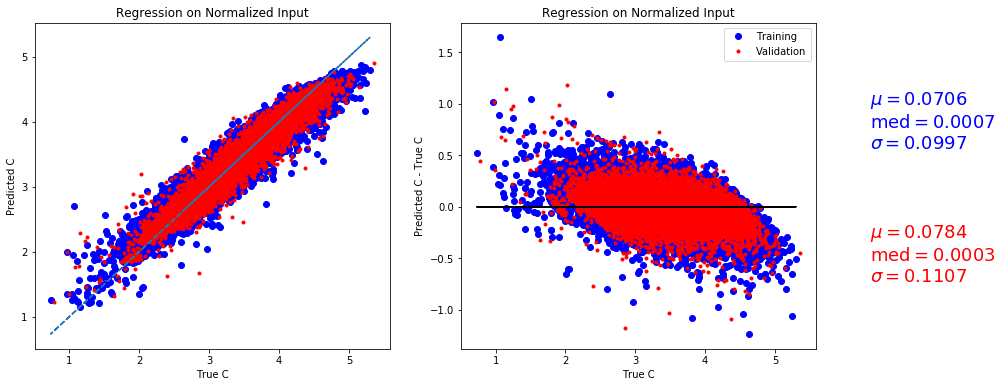

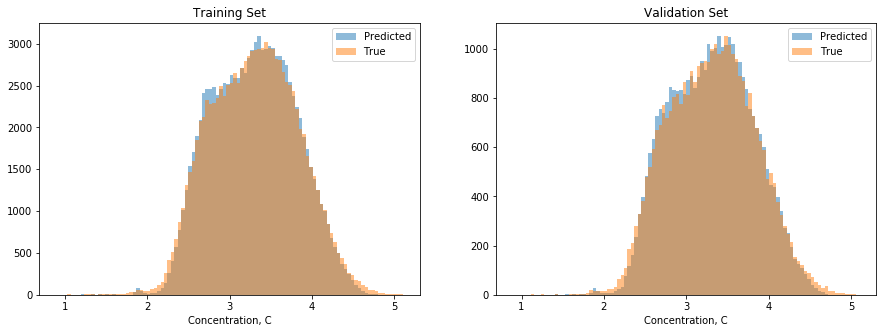

In [15]:
# define hyper parameters
KNN = KNeighborsRegressor(n_neighbors=10, p=2)

# fit the model with training set
KNN.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr_norm)  
target_va_pred= KNN.predict(input_va_norm)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True C')
ax1.set_ylabel('Predicted C')
ax1.set_title('Regression on Normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True C')
ax2.set_ylabel('Predicted C - True C')
ax2.set_title('Regression on Normalized Input')
ax2.legend(['Training', 'Validation'])

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(target_tr-target_tr_pred)

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Concentration, C')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Concentration, C')
ax2.legend(fancybox = True)

plt.show()

For this data set and target, it can be seen that the model performs much better. There is a clear trend about the line equality in both plots and the mean absolute difference between the predicted and true concentrations is a very reasonable 0.08.

Together with the distributions, it can be seen that the model struggles the most with very high and low concentrations. These are relatively rare and when averaging over many neighbours, it will always bring the prediction towards the mean of the target distribution.

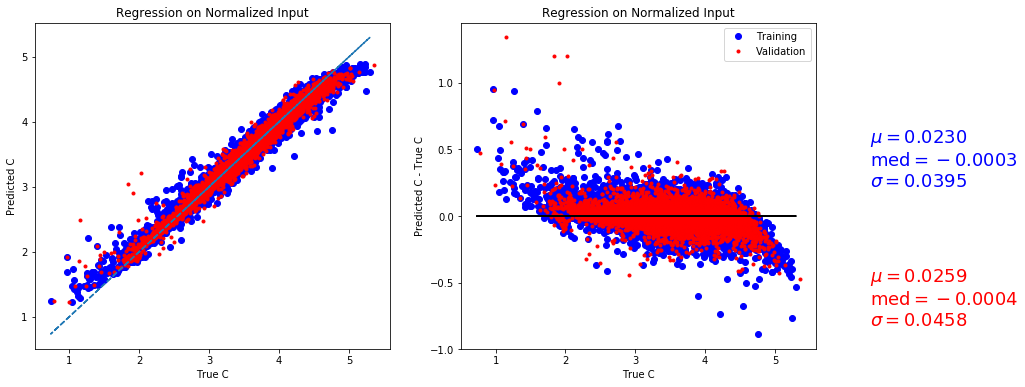

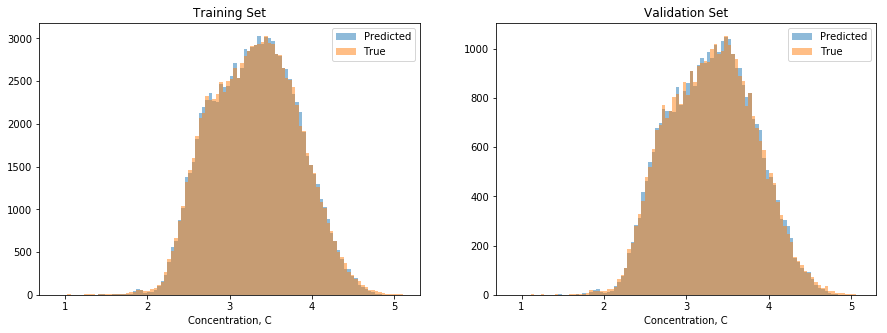

In [16]:
# define hyper parameters
KNN = KNeighborsRegressor(n_neighbors=10, p=2)

# fit the model with training set
KNN.fit(input_tr,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr)  
target_va_pred= KNN.predict(input_va)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True C')
ax1.set_ylabel('Predicted C')
ax1.set_title('Regression on Normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True C')
ax2.set_ylabel('Predicted C - True C')
ax2.set_title('Regression on Normalized Input')
ax2.legend(['Training', 'Validation'])

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(target_tr-target_tr_pred)

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Concentration, C')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Concentration, C')
ax2.legend(fancybox = True)

plt.show()

Peculiarly, when training on un-normalized data, the model performs better for most galaxies (approx 4x lower sigma and mu). But at the cost of performing very poorly for a select few galaxies.

I think normalization is not vital for this case because, as I will discuss in the next notebook, the most important input parameter is the Gini index. Gini is naturally bound between 0 and 1 and is highly correlated with concentration. Perhaps not normalizing actually helps the model by making nuisance parameters "further" away in parameter space, ie. less important for identifying the nearest neighbours.

## Conclusions

1. Non-parametric morphologies attempt to take a very complex system (2D projection of galaxy morphology) and reduce it to a few simple statistics. This is not conducive salient enough to predict global galaxy properties.
2. Non-parametric morphology statistics can be equal for galaxies with very different global properties (pre-mergers, post-mergers, etc.) which only works to confuse simple models and regress towards the mean of the target distribution.
3. Non-parametric morphology statistics can predict other morphology statistics. This makes sense as many of these statistics are derived using similar methods.
4. Normalizing the data does not seem to help the KNN regressional model. In fact, it was seen to actually hinder the model's performance.